In [1]:
import numpy as np 
import matplotlib.ticker
from scipy.special import factorial
import pylab as pl
import random
from scipy import stats

### Define parameters

In [2]:
Nt = 2000 # number of time points
k = 8
dtime = 0.001
buff_len = 10
delta = 27 # jump in the program memory from one instruction to the next
thr_double_peak = 0.05 # big T activaiton threshold (this is only a temporary solution)
ev_trh = 0.001 # evidence accumulation threshold
t_thr = 10**-8 # -7 #threshold for small t to indicate input stimuli that were just presented
probe_size = 0 # how many items does the probe stimulus contain - useful for "attend to probe"
# initialize evidence accumulation
ev_left = 0
ev_right = 0

### Create supported dimension

In [3]:
class Support:
    
    def __init__(self, tstr_min=0.1, tstr_max=0.5, buff_len=10, k=8, dtime=0.001, g = 0):
        self.tstr_min = tstr_min
        self.tstr_max = tstr_max
        self.buff_len = buff_len
        self.k = k
        self.dtime = dtime
        self.len_time = Nt*dtime
        self.g = g
        
        self.N = self.buff_len+2*self.k
        self.Nt = int(self.len_time/self.dtime)

        #Create power-law growing Taustarlist and corresponding s
        a = (self.tstr_max/self.tstr_min)**(1./buff_len)-1
        pow_vec = np.arange(-self.k,buff_len + self.k) #-1
        self._Taustarlist = self.tstr_min * (1 + a)**pow_vec

        s = self.k/self._Taustarlist
        
        #Create DerivMatrix
        self._DerivMatrix = np.zeros((self.N,self.N))
        for i in range(1,self.N-1):
            self._DerivMatrix[i, i-1] = -(s[i+1]-s[i])/(s[i]-s[i-1])/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i] = ((s[i+1]-s[i])/(s[i]- s[i-1])-(s[i]-s[i-1])/(s[i+1]-s[i]))/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i+1] = (s[i]-s[i-1])/(s[i+1]-s[i])/(s[i+1] - s[i-1])

        self.t = np.zeros((self.N,self.Nt))
        self.T = np.zeros((self.N,self.Nt))
        self._s = s
        
    def update(self, time_index, f=np.zeros(Nt), alpha = 1):
        self.t[:,time_index] = self.t[:,time_index-1]+(alpha*(-self._s.T*self.t[:,time_index-1]+f[time_index])*self.dtime)
        # to avoid numerical errors if small t grows too high - t
        #div_on = 0
        if np.max(self.t[:,time_index]) > 0.01:
            self.t[:,time_index] = np.zeros(self.N)
        #    self.t[:,time_index] = self.t[:,time_index]/10
        #    div_on = 1
        t_diff = np.dot(np.linalg.matrix_power(self._DerivMatrix, self.k), self.t[:,time_index])
        L1 = (-1)**self.k*self._s**(self.k+1) # this can be taken out
        L2 = t_diff/factorial(self.k)
        L2 = L2*(self._Taustarlist**self.g)
        self.T[:,time_index] = L1.T*L2.T
        #if div_on:
        #    self.T[:,time_index] = self.T[:,time_index]*10
        self.T[self.T[:,time_index]<0,time_index] = 0 # in case of numerical errors
        
    def jump(self, time_index, delta):
        R = np.diag(np.exp(delta*self._s))
        self.t[:,time_index] = np.dot(R,self.t[:,time_index]);

### Create an input node prototype

In [4]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support(tstr_min=0.1, tstr_max=2, buff_len=70, g=1) # g=1 - to make big T equal amplitude
        self.value = np.zeros(Nt)           

### Create an action node prototype

In [5]:
class action_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt) 

### Create program class

In [6]:
class program:
    
    def __init__(self):
        pass
    
    class dms:
        
        def __init__(self):
            
            self.alpha = -1 # default is to run the program
            global probe_size, actions, action_names, alpha_factor
            alpha_factor = 20000
            probe_size = 1 # only one probe presented at a time
            action_names = ['attend_to_probe', 'diff', 'release', 'take_reward']
            actions = []
            for name in action_names:
                actions.append(action_node(name))
            
        def start(self, time_index, k=8):
            
            s = actions[0].support._s
                        
            actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+3]*s)
            
            #actions[action_names.index('attend_to_probe_2')].support.t[:,time_index-1] = \
            #dtime*np.exp(-actions[0].support._Taustarlist[k+2]*s)
            
            # normally the two peaks would end up too close to be detectable 
            # so when first peak is detected i decrease it by the impulse response peak amplitude to make second peak
            # detectable
            actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] = \
                actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] + \
                dtime*np.exp(-actions[0].support._Taustarlist[k+4]*s)
                        
            actions[action_names.index('diff')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+5]*s)
            
            actions[action_names.index('release')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+6]*s)
            
            actions[action_names.index('take_reward')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+7]*s)
                
            actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] = \
                actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] + \
                dtime*np.exp(-actions[0].support._Taustarlist[k+7]*s)
            
            actions[action_names.index('take_reward')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+8]*s)
                
        def set_alpha(self, alpha):
            self.alpha = alpha
            
            
    class jor:
        
        def __init__(self):
            
            self.alpha = -1 # default is to run the program
            global probe_size, actions, action_names, alpha_factor
            alpha_factor = 5000
            probe_size = 2 # two probes presented at the same time
            action_names = ['attend_to_probe', 'diff', 'left', 'right', 'take_reward']
            actions = []
            for name in action_names:
                actions.append(action_node(name))
            
        def start(self, time_index, k=8):
            
            s = actions[0].support._s
                        
            actions[action_names.index('attend_to_probe')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+3]*s)
                        
            actions[action_names.index('diff')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+4]*s)
            
            actions[action_names.index('left')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+5]*s)
            
            actions[action_names.index('right')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+6]*s)
            
            actions[action_names.index('take_reward')].support.t[:,time_index-1] = \
                dtime*np.exp(-actions[0].support._Taustarlist[k+6]*s)
                     
        def set_alpha(self, alpha):
            self.alpha = alpha

### Describe specific actions

In [7]:
# complete the action 
def finish_action(name):
    s = actions[0].support._s
    # if the amplitude was particularly high - meaning we have two peaks next tow each other
    if actions[action_names.index(name)].support.T[k,time_index] >= thr_double_peak:
        actions[action_names.index(name)].value[time_index+1] = 1.
        jump_program_memory(delta)
        # print the time stamp
        print('extend action')
        print time_index
        print name
    # when any element of small t becomes negative we zero those elemnts to avoid numerical error
    actions[action_names.index(name)].support.t[\
        actions[action_names.index(name)].support.t[:,time_index]<0,time_index] = 0
    # when any element of small t becomes negative we zero them all to avoid numerical error
    #if min(actions[action_names.index(name)].support.t[:,time_index])<0:
    #    actions[action_names.index(name)].support.t[:,time_index] = np.zeros(buff_len+2*k)
    
# scan through the input space and find a change
# for the moment this just tests if there is a non-zero input
def attend_to_probe():
    # pause the program since no input
    program_name.set_alpha(0)
    change = 0
    # test if the input has probe_size active nodes
    if sum([inputs[input_names.index(name)].value[time_index] for name in input_names]) == probe_size:
        # stop decay of the input neuron
        #inputs[input_names.index(name)].support.alpha = 0
        # move the program forward (technically backward)
        program_name.set_alpha(-1)
        change = 1
        finish_action('attend_to_probe')
    if not change: # if no change was found keep this node active
        actions[action_names.index('attend_to_probe')].value[time_index+1] = 1.

# initialize memory scanner        
def scanner_init():
    scanner = Support(g=1) #2 # this produces growing amplitude of temporal receptive fields
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    scanner.update(0, f_tmp)
    return scanner

# scans memory along target input node at i-th time step in the past 
def scan(scanner, target_name, i):
    #return sum(scanner.T[k:-k,i]*inputs[input_names.index(target_name)].support.T[k:-k,time_index])
    ev = inputs[input_names.index(target_name)].support.T[k+i,time_index]
    return ev

# initialize evidence accumulator
def ev_acc_init():
    # evidence accumulators
    global evidence_l, evidence_r
    evidence_l = Support(tstr_min=0.1, tstr_max=1, buff_len=70, g=1)
    evidence_r = Support(tstr_min=0.1, tstr_max=1, buff_len=70, g=1)
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    evidence_l.update(0, f_tmp)
    evidence_r.update(0, f_tmp)
    return evidence_l, evidence_r
        
        
# accumulate evidence
def ev_acc(evidence, ev_acc_time, alpha=0):
    evidence.update(ev_acc_time, np.zeros(Nt), alpha*alpha_factor)
    if evidence.T[k+10, ev_acc_time] > ev_trh:
        ev = 1
    else:
        ev = 0
    return ev
        
        
# compare currently present stimulus with the next most recent stimulus            
def diff():
    global ev_left, ev_right, reaction_time, lag
    program_name.set_alpha(0)
    # initialize evidence accumulation
    evidence_l, evidence_r = ev_acc_init()
    # find all the stimuli were just presented (looking into small t because it's no longer in f and big T did not 
    # peak at first taustar yet)
    target = []
    lag = []
    for no, name in enumerate(input_names):
        if inputs[input_names.index(name)].support.t[0,time_index] > t_thr:
            target.append(name)
            lag.append(len(input_names)-no)
    # now we need to scan the memory to find if previous stimulus was same or differet
    scanner = scanner_init()
    # scan trhough all taustars and send the output to evidence accumulator
    limit = int((scanner.tstr_max-scanner.tstr_min)/dtime)
    for i in range(evidence_l.buff_len): #range(limit):
        ev_acc_step = 0 # when accumulating multiple item in case none of them is different from zero
        for name in input_names:
            ev = scan(scanner, name, i)
            if len(target) == 1:
                if name == target[0]:
                    ev_left = ev_acc(evidence_l, i+1, alpha=ev)
                else:
                    if ev > 0:
                        ev_acc_step = 1 # found evidence different from zero, step made
                        ev_right = ev_acc(evidence_r, i+1, alpha=ev)
            if len(target) == 2:
                if name == target[0]:
                    ev_left = ev_acc(evidence_l, i+1, alpha=ev)
                if name == target[1]:
                    ev_right = ev_acc(evidence_r, i+1, alpha=ev)
        if len(target) == 1 and ev_acc_step == 0: # if no evidence was found make a step forward
            ev_right = ev_acc(evidence_r, i+1, alpha=0)
        if ev_left == 1 or ev_right == 1:
            print 'reaction time'
            print i
            reaction_time = i
            program_name.set_alpha(-1)
            finish_action('diff')
            return
        scanner.update(i+1,np.zeros(Nt),alpha=i/100) #
    
def release():
    # if not enough evidence accumulated do not release
    if not ev_left:
        actions[action_names.index('release')].value[time_index] = 0
    # if enough evidence was accumulated attenuate attend_to_probe
    else:
        actions[action_names.index('attend_to_probe')].support.t[:,time_index] = np.zeros(buff_len+2*k)
    finish_action('release')
    
def left():
    if not ev_left:
        actions[action_names.index('left')].value[time_index] = 0
    finish_action('left')

def right():
    if not ev_right:
        actions[action_names.index('right')].value[time_index] = 0
    finish_action('right')

def take_reward():
    finish_action('take_reward')
    

### Update memory at every time step

In [8]:
def update_input_memory():
    for name in input_names:
        inputs[input_names.index(name)].support.update(time_index, inputs[input_names.index(name)].value)
    
def update_program_memory():    
    for name in action_names:
        actions[action_names.index(name)].support.update(time_index, np.zeros(Nt), program_name.alpha)
        
def jump_program_memory(delta):    
    for name in action_names:
        actions[action_names.index(name)].support.jump(time_index, delta*dtime)
        
def check_program_memory():
    program_name.set_alpha(-1) # set back to -1
    for name in action_names:
        #if(actions[action_names.index(name)].support.T[k,time_index] >= thr): # if reached a peak
        if(actions[action_names.index(name)].support.T[k,time_index-1] > \
           actions[action_names.index(name)].support.T[k,time_index-2] and \
           actions[action_names.index(name)].support.T[k,time_index] < \
           actions[action_names.index(name)].support.T[k,time_index-1] and \
           actions[action_names.index(name)].support.T[k,time_index] >= 0.02): # if reached a peak
            print('peak')
            print time_index
            print name
            actions[action_names.index(name)].value[time_index] = 1. # made the corresponding action node active
        if actions[action_names.index(name)].value[time_index]: # it was either a peak or it was active from before
            eval(name+'()') # call the function that nodes is connected with 
                            # this could be solved in a more elegant way if action_names is a dictionary 
            #print('run action')
            #print time_index
            #print name

### Plot stuff

In [9]:
%matplotlib inline
#%matplotlib notebook
pl.ion()

def plot_inputs():
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        _ = pl.plot(inputs[input_names.index(name)].value, color='blue')
        
def plot_memory():
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        #_ = pl.scatter(time_index, inputs[input_names.index(name)].support.T[k:-k,time_index], color='blue')
        _ = pl.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
        
def plot_inputs_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        ax = pl.subplot(3, len(input_names), idx+1)
        ax.set_title(input_names[idx])
        ax.plot(inputs[input_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+len(input_names))
        ax.plot(inputs[input_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+2*len(input_names))
        ax.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
def plot_actions_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = actions[0].support.k
    for idx, name in enumerate(action_names):
        ax = pl.subplot(3, len(action_names), idx+1)
        ax.set_title(action_names[idx])
        ax.plot(actions[action_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+len(action_names))
        ax.plot(actions[action_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+2*len(action_names))
        ax.plot(actions[action_names.index(name)].support.T[k:-k,:].T, color='blue')

### Generate radom data

In [10]:
def generate_jor_data():
    global inputs, input_names
    input_names = ['R', 'Y', 'T', 'X', 'Q','G','K']
    #random.shuffle(input_names)
    probes = random.sample(input_names, 2)
    inputs = []
    for name in input_names:
        inputs.append(input_node(name))
    # zero all inputs
    for name in input_names:
        inputs[input_names.index(name)].value = np.zeros(Nt)
    # put the letters every 100 time steps
    for input_no, input_name in enumerate(input_names):
        inputs[input_names.index(input_name)].value[(input_no+1)*200] = 1
    # add two probes at the end
    for probe_no, probe_name in enumerate(probes):
        inputs[input_names.index(probe_name)].value[(input_no+1)*200+200] = 1
    print inputs
    
            
def generate_dms_data():
    global inputs, input_names
    input_names = ['cat', 'dog', 'sports car', 'sedan car']
    inputs = []
    for name in input_names:
        inputs.append(input_node(name))
    # zero all inputs
    for name in input_names:
        inputs[input_names.index(name)].value = np.zeros(Nt)
    probe1 = 3 #random.randint(1, 4)
    inputs[probe1-1].value[200] = 1
    match_trial = 1 #random.randint(0,1)
    if match_trial:
        inputs[probe1-1].value[400] = 1
    else:
        if probe1 == 1:
            probe2 = 2
        elif probe1 == 2:
            probe2 = 1
        elif probe1 == 3:
            probe2 = 4
        elif probe1 == 4:
            probe2 = 3
        inputs[probe2-1].value[400] = 1
        inputs[probe1-1].value[600] = 1
    
def run_simulation(fname, ntrials=1):
    global time_index, inputs, input_names, lags, reaction_times
    lags = []
    reaction_times = []
    for trial in range(ntrials):
        print trial
        print trial
        fname() # generates the data
        time_index = 1
        program_name.start(time_index)
        update_program_memory()
        for time_index in range(2,Nt-1):
            # make memory decay for one time step
            update_input_memory()
            update_program_memory()
            # check if program memory activates node - since it runs backwards
            check_program_memory()
        lags.append(lag)
        reaction_times.append(reaction_time)

### Generate task specific figures

In [11]:
def make_jor_figures():
    
    # lag of more recent item vs RT
    fig = pl.figure
    l_recent = [x[1] for x in lags]
    ax = pl.subplot(111)
    ax.plot(l_recent, reaction_times, '.', color='k')
    pl.ylabel('response time [arbitrary units]')
    pl.xlabel('lag of the more recent item (log spacing)')

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(l_recent),reaction_times)

    lag_times = np.arange(1,7)
    ax.plot(lag_times, slope*np.log(lag_times) + intercept, color='k')

    ax.set_xscale("log", nonposx='clip')
    ax.set_xticks(np.arange(1,7)) 
    ax.set_xticklabels([str(i) for i in range(1,7)])

    pl.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    #pl.savefig("lag_more_recent_vs_RT_v1.pdf")

    pl.show()
    
    
    # lag vs RT
    fig = pl.figure
    ax = pl.subplot(111)
    l_distant = [x[0] for x in lags]

    for k, i in enumerate(np.sort(list(set(reaction_times)))): 
        ind = np.array([t for t, x in zip(range(len(reaction_times)), reaction_times) if x == i])
        ax.plot([l_distant[j] for j in ind], [reaction_times[j] for j in ind], '.', color=str(k/6.))

    pl.ylabel('response time [arbitrary units]')
    pl.xlabel('lag of the less recent item')

    #pl.savefig("lag_vs_RT_v1.pdf")

    pl.show()


In [12]:
program_name = program.jor()
run_simulation(fname=generate_jor_data, ntrials=100)

#program_name = program.dms()
#run_simulation(fname=generate_dms_data, ntrials=1)

0
0
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c26af80>, <__main__.input_node instance at 0x1a0c26afc8>, <__main__.input_node instance at 0x1a0c26acf8>, <__main__.input_node instance at 0x1a0c26ac20>, <__main__.input_node instance at 0x1a0c26ad40>, <__main__.input_node instance at 0x1a0c26ab90>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
65
peak
1662
left
peak
1701
right
peak
1701
take_reward
1
1
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c26afc8>, <__main__.input_node instance at 0x1a0c26acf8>, <__main__.input_node instance at 0x1a0c26ac20>, <__main__.input_node instance at 0x1a0c26ad40>, <__main__.input_node instance at 0x1a0c26ab90>, <__main__.input_node instance at 0x1a0c26a8c0>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
53
peak
1662
left
peak
1701
right
peak
1701
take_reward
2
2
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c26acf8>,

peak
1628
diff
reaction time
60
peak
1662
left
peak
1701
right
peak
1701
take_reward
19
19
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c254d88>, <__main__.input_node instance at 0x1a0c254cb0>, <__main__.input_node instance at 0x1a0c2547e8>, <__main__.input_node instance at 0x1a0c2544d0>, <__main__.input_node instance at 0x1a0c254950>, <__main__.input_node instance at 0x1a0c254878>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
60
peak
1662
left
peak
1701
right
peak
1701
take_reward
20
20
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c254cb0>, <__main__.input_node instance at 0x1a0c2547e8>, <__main__.input_node instance at 0x1a0c2544d0>, <__main__.input_node instance at 0x1a0c254950>, <__main__.input_node instance at 0x1a0c254878>, <__main__.input_node instance at 0x1a0c254680>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
30
peak
1662
left
peak
1701
right
peak
1701
take_reward
21
21
[<__m

37
37
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c254ea8>, <__main__.input_node instance at 0x1a0c2541b8>, <__main__.input_node instance at 0x1a0c254878>, <__main__.input_node instance at 0x1a0c254320>, <__main__.input_node instance at 0x1a0c254200>, <__main__.input_node instance at 0x1a0c2540e0>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
44
peak
1662
left
peak
1701
right
peak
1701
take_reward
38
38
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c2541b8>, <__main__.input_node instance at 0x1a0c254878>, <__main__.input_node instance at 0x1a0c254320>, <__main__.input_node instance at 0x1a0c254200>, <__main__.input_node instance at 0x1a0c2540e0>, <__main__.input_node instance at 0x1a0c254a28>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
30
peak
1662
left
peak
1701
right
peak
1701
take_reward
39
39
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c25

peak
1628
diff
reaction time
53
peak
1662
left
peak
1701
right
peak
1701
take_reward
56
56
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c2459e0>, <__main__.input_node instance at 0x1a0c245ea8>, <__main__.input_node instance at 0x1a0c245e60>, <__main__.input_node instance at 0x1a0c245dd0>, <__main__.input_node instance at 0x1a0c245cb0>, <__main__.input_node instance at 0x1a0c245ef0>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
53
peak
1662
left
peak
1701
right
peak
1701
take_reward
57
57
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c245ea8>, <__main__.input_node instance at 0x1a0c245e60>, <__main__.input_node instance at 0x1a0c245dd0>, <__main__.input_node instance at 0x1a0c245cb0>, <__main__.input_node instance at 0x1a0c245ef0>, <__main__.input_node instance at 0x1a0c245fc8>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
30
peak
1662
left
peak
1701
right
peak
1701
take_reward
58
58
[<__m

74
74
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c21b3b0>, <__main__.input_node instance at 0x1a0c21b368>, <__main__.input_node instance at 0x1a0c21b3f8>, <__main__.input_node instance at 0x1a0c21b440>, <__main__.input_node instance at 0x1a0c21b1b8>, <__main__.input_node instance at 0x1a0c21b4d0>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
60
peak
1662
left
peak
1701
right
peak
1701
take_reward
75
75
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c21b368>, <__main__.input_node instance at 0x1a0c21b3f8>, <__main__.input_node instance at 0x1a0c21b440>, <__main__.input_node instance at 0x1a0c21b1b8>, <__main__.input_node instance at 0x1a0c21b4d0>, <__main__.input_node instance at 0x1a0c21b5a8>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
53
peak
1662
left
peak
1701
right
peak
1701
take_reward
76
76
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c21

peak
1628
diff
reaction time
44
peak
1662
left
peak
1701
right
peak
1701
take_reward
93
93
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c21b518>, <__main__.input_node instance at 0x1a0c21b440>, <__main__.input_node instance at 0x1a0c21b878>, <__main__.input_node instance at 0x1a0c21b368>, <__main__.input_node instance at 0x1a0c21b710>, <__main__.input_node instance at 0x1a0c21b830>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
44
peak
1662
left
peak
1701
right
peak
1701
take_reward
94
94
[<__main__.input_node instance at 0x1a0c26a2d8>, <__main__.input_node instance at 0x1a0c21b440>, <__main__.input_node instance at 0x1a0c21b878>, <__main__.input_node instance at 0x1a0c21b368>, <__main__.input_node instance at 0x1a0c21b710>, <__main__.input_node instance at 0x1a0c21b830>, <__main__.input_node instance at 0x1a0c21b998>]
peak
28
attend_to_probe
peak
1628
diff
reaction time
30
peak
1662
left
peak
1701
right
peak
1701
take_reward
95
95
[<__m

### Visualize results

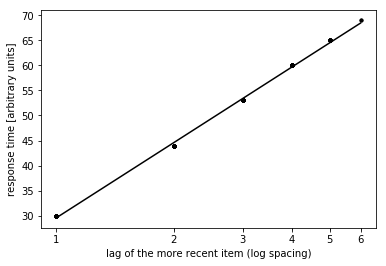

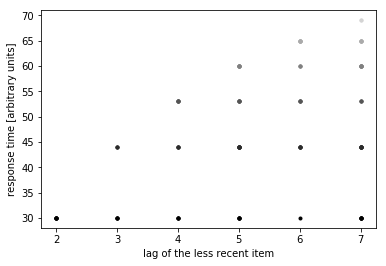

In [13]:
make_jor_figures()

### Visualize results of the last trial

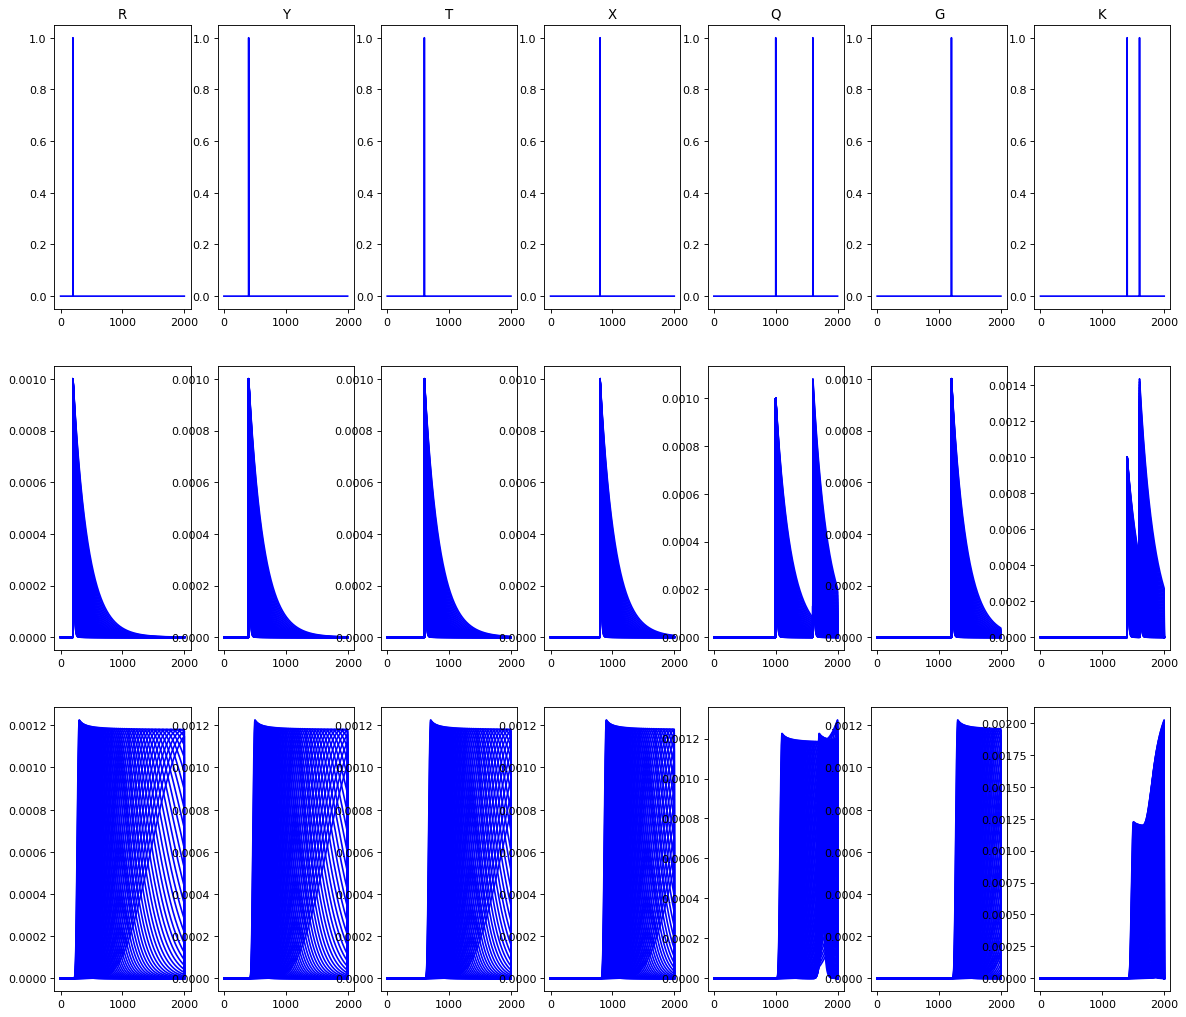

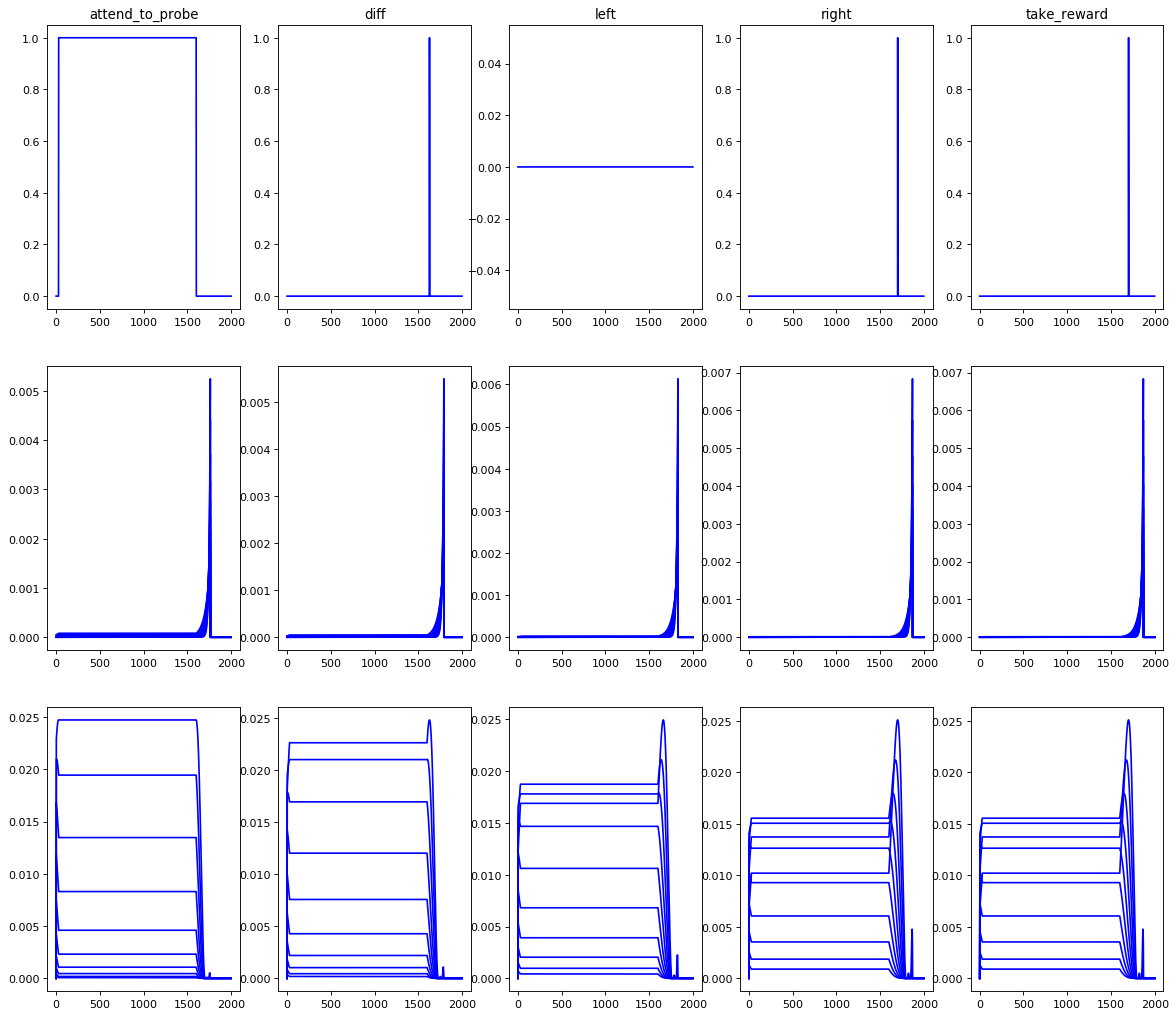

In [14]:
pl.tight_layout()

plot_inputs_memory()
plot_actions_memory()

### Visualize evidence accumulation and decition making

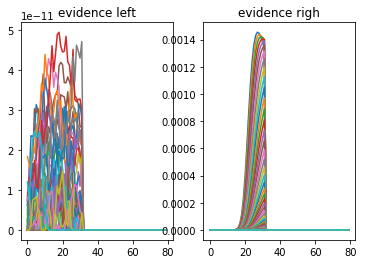

In [15]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k:-k,0:80].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k:-k,0:80].T)
_ = ax.set_title('evidence righ')

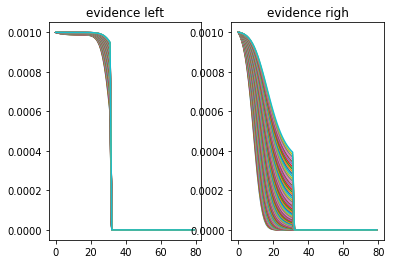

In [16]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.t[k:-k,0:80].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.t[k:-k,0:80].T)
_ = ax.set_title('evidence righ')

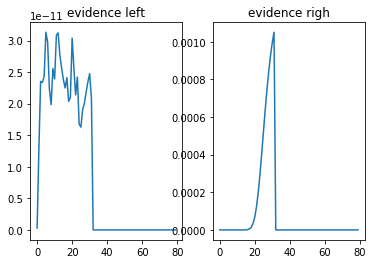

In [17]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k+10,0:80].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k+10,0:80].T)
_ = ax.set_title('evidence righ')

### Other visualizations and test

[59. 56. 52. 47. 40. 32. 17.]
[ -3.  -4.  -5.  -7.  -8. -15.]


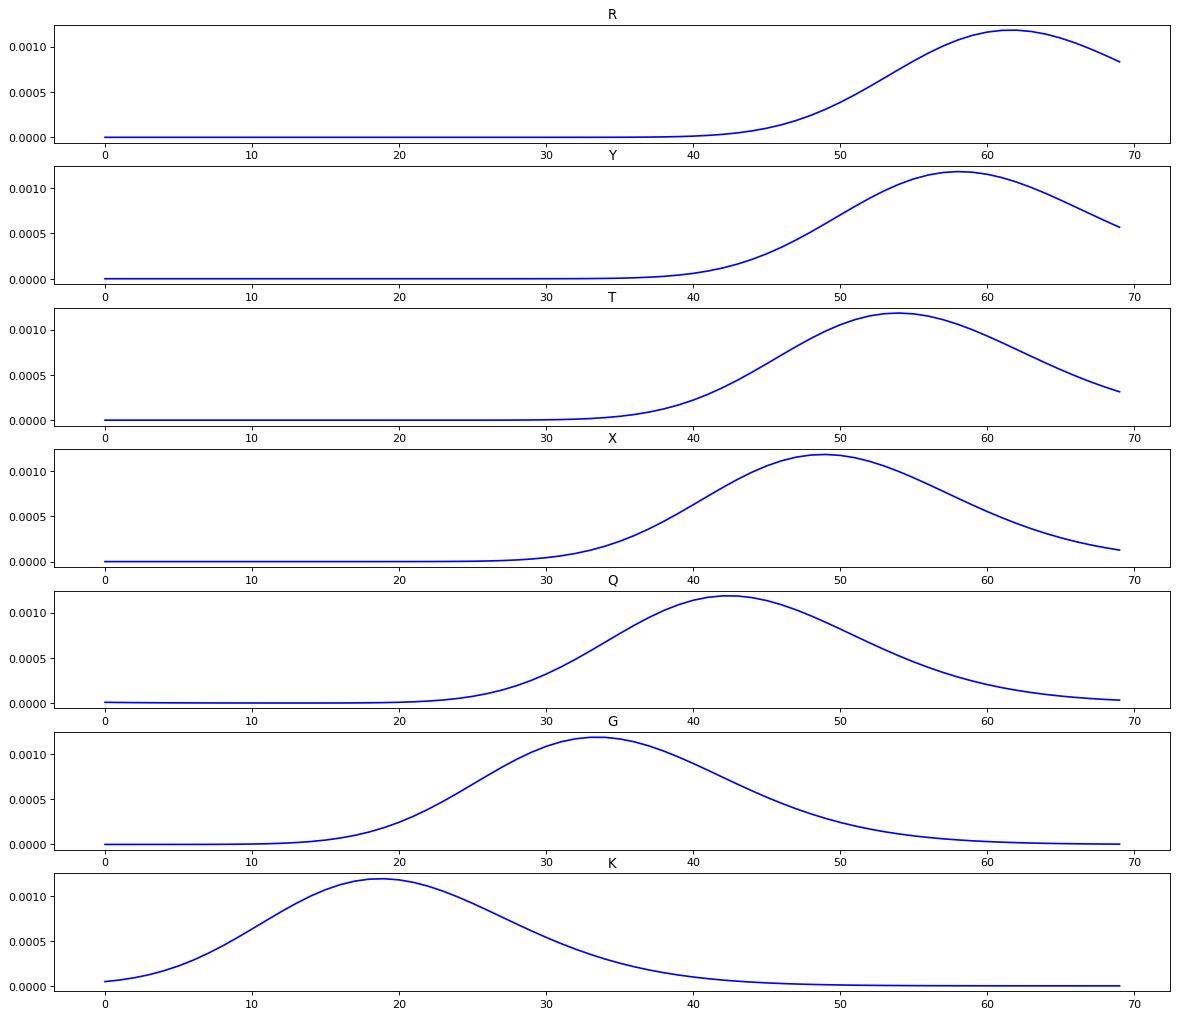

In [18]:
fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

#for idx, name in enumerate(input_names):
#    _ = pl.subplot(len(input_names), 1, idx+1)
#    _ = pl.plot(inputs[input_names.index(name)].value, color='blue')

l = np.zeros((7))
for idx, name in enumerate(input_names):
    #print name
    tot = 0
    for i in range(60):
        tot += inputs[input_names.index(name)].support.T[k+5+i,1628]
        if tot > 0.015:
            #print i
            break
    l[idx] = i

print l
print np.diff(l)

for idx, name in enumerate(input_names):
    #print name
    #print sum(inputs[input_names.index(name)].support.T[k:k+20,1628])
    _ = pl.subplot(len(input_names), 1, idx+1)
    _ = pl.plot(inputs[input_names.index(name)].support.T[k:-k,1628], color='blue')
    pl.title(name)

28
[4.90297911e-21 2.04485751e-18 3.38789087e-16 2.57331262e-14
 1.01106381e-12 2.27491063e-11 3.19368421e-10 3.00728754e-09
 2.01895862e-08 1.01752173e-07 4.02116501e-07 1.29289035e-06
 3.48918147e-06 8.11547466e-06 1.66363680e-05 3.06340183e-05
 5.14927739e-05 8.00982822e-05 1.16647726e-04 1.60615586e-04
 2.10860757e-04 2.65823040e-04 3.23747798e-04 3.82889375e-04
 4.41664732e-04 4.98748505e-04]
4.902979109754001e-21
151
[1.94690464e-07 1.24236438e-06 5.22306660e-06 1.59037577e-05
 3.77560384e-05 7.39919357e-05 1.25090485e-04 1.88719610e-04
 2.60765026e-04 3.36642564e-04 4.12286424e-04 4.84633886e-04
 5.51704014e-04 6.12447406e-04 6.66513324e-04 7.14021064e-04
 7.55373435e-04 7.91120593e-04 8.21868533e-04 8.48222054e-04
 8.70752124e-04 8.89979478e-04 9.06368406e-04 9.20326599e-04
 9.32208312e-04 9.42319154e-04]
1.9469046415131822e-07
183
[0.00067184 0.0014451  0.00233594 0.00308029 0.00352364 0.00365949
 0.00356694 0.00334183 0.00306062 0.00277232 0.00250328 0.00226482
 0.00205968 0.

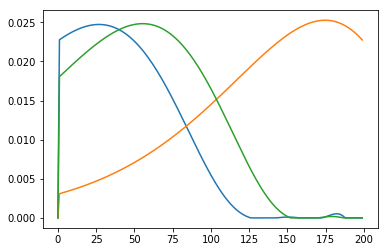

In [19]:
buff_len = 10
Nt = 200
test = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test2 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test3 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
s = test._s
test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
#test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+4]*s)
#test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+7]*s)
test2.t[:,0] = test2.t[:,0] + dtime*np.exp(-test2._Taustarlist[k+7]*s)
test3.t[:,0] = test3.t[:,0] + dtime*np.exp(-test3._Taustarlist[k+4]*s)
first_time = 1
for i in range(Nt-1):
    if(test.T[k,i-1] > test.T[k,i-2] and test.T[k,i] < test.T[k,i-1]):
        #test.t[:,i] = test.t[:,i] - dtime*np.exp(-(test._Taustarlist[k])*s)
        #if first_time:
        #    a = test3.t[:,i]
        #    first_time = 0
        #test.t[:,i] = test.t[:,i] - a # test3.t[:,i]
        #test.t[:,i] = test.t[:,i] - np.repeat(min(test.t[:,i]), buff_len+2*k)
        #test.t[test.t[:,i]<0,i] = 0
        #test.update(i+1, np.zeros(Nt), alpha = -1000)
        print i
        print test.t[:,i]
        print min(test.t[:,i])
    test.update(i+1, np.zeros(Nt), alpha = -1)
    test2.update(i+1, np.zeros(Nt), alpha = -1)
    test3.update(i+1, np.zeros(Nt), alpha = -1)
       
    #    print("test")
    #    test2.update(i+1, np.zeros(Nt), alpha = -27)
    #    print np.max(test.T[k,0:200].T)
        #_ = pl.plot(test.t[:,i])
        #_ = pl.plot(test.T[k,0:280].T)
        #_ = pl.plot(test2.T[k,0:280].T)
    
_ = pl.plot(test.T[k,0:Nt].T)
_ = pl.plot(test2.T[k,0:Nt].T)
_ = pl.plot(test3.T[k,0:Nt].T)

#print np.argmax(test.T[k,:].T)
#print np.argmax(test2.T[k,:].T)

#print test._Taustarlist

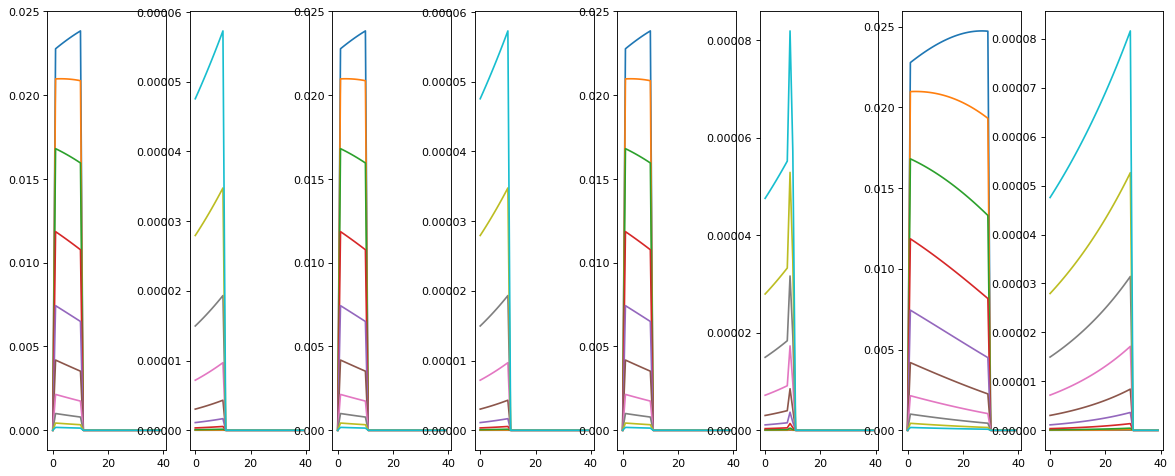

In [20]:
buff_len = 10
Nt = 40
test = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)
test2 = Support(tstr_min=0.1, tstr_max=0.5, buff_len=buff_len, k=8, dtime=0.001)


s = test._s
test.t[:,0] = test.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
test2.t[:,0] = test2.t[:,0] + dtime*np.exp(-test._Taustarlist[k+3]*s)
for i in range(10):
    test.update(i+1, np.zeros(Nt), alpha = -1)
    test2.update(i+1, np.zeros(Nt), alpha = -1)

fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = pl.subplot(2, 8, 1)
_ = ax.plot(test.T[k:-k,:].T)
ax = pl.subplot(2, 8, 2)
_ = ax.plot(test.t[k:-k,:].T)


ax = pl.subplot(2, 8, 3)
_ = ax.plot(test2.T[k:-k,:].T)
ax = pl.subplot(2, 8, 4)
_ = ax.plot(test2.t[k:-k,:].T)

#test.update(i+1, np.zeros(Nt), alpha = -20)
test.jump(i, 20*dtime)

ax = pl.subplot(2, 8, 5)
_ = ax.plot(test.T[k:-k,:].T)
ax = pl.subplot(2, 8, 6)
_ = ax.plot(test.t[k:-k,:].T)

for l in range(20):
    test2.update(i+l+1, np.zeros(Nt), alpha = -1)
    
ax = pl.subplot(2, 8, 7)
_ = ax.plot(test2.T[k:-k,:].T)
ax = pl.subplot(2, 8, 8)
_ = ax.plot(test2.t[k:-k,:].T)